### Libraries

Tudo da vida segue uma distribuição gaussiana.
-V.C.A Marcelo

In [1]:
import pandas as pd
import sklearn
import numpy as np

Reading dataframes

In [2]:
df_wowtoken = pd.read_csv('df_wowtoken.csv')
df_currency = pd.read_csv('df_currency.csv')

Drop ```Unnamed: 0``` column

In [3]:
df_wowtoken.drop('Unnamed: 0', axis=1, inplace=True)
df_currency.drop('Unnamed: 0', axis=1, inplace=True)

Converting date to datetime

In [4]:
df_wowtoken['date'] = pd.to_datetime(df_wowtoken['date'], infer_datetime_format=True)
df_currency['date'] = pd.to_datetime(df_currency['date'], infer_datetime_format=True)

# Configuration

```n_samples```: data to be trained <br>
```n_predict```: data to be predict

In [11]:
n_samples = 1000 # train
n_predict = 1 # test

dates = df_wowtoken['date']
wowtoken = df_wowtoken['Eu']
currency = df_currency['Eur']

## Scaling 0 - 1

In [12]:
from sklearn.preprocessing import MinMaxScaler

y1 = np.array(wowtoken[:n_samples]).reshape(n_samples,-1)
y2 = np.array(currency[:n_samples]).reshape(n_samples,-1)

# Scaling 0 - 1
sc = MinMaxScaler()
y1_sc = sc.fit_transform(y1)
y2_sc = sc.fit_transform(y2)

# SEPARAR POR DIA AS DATAS
df_scaled = pd.DataFrame(data=(y1_sc.flatten(),y2_sc.flatten())).T
df_scaled['wowtoken'] = y1
df_scaled['currency'] = y2
df_scaled.reset_index(inplace=True)
df_scaled.drop(columns=['index', 0, 1], axis=1, inplace=True)

## Linear Regression

score:  0.057665768460206546
coef:   -0.002378737358737362


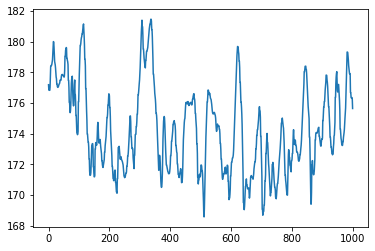

In [13]:
from sklearn.linear_model import LinearRegression

y = np.array(wowtoken[:n_samples])
x = np.arange(n_samples).reshape(n_samples, -1)

reg = LinearRegression().fit(x,y)

LR_a_predict = np.arange(n_samples, n_samples+n_predict).reshape(n_predict, -1)
LR_v_predict = reg.predict(LR_a_predict)

print('score: ',reg.score(x,y))
print('coef:  ',reg.coef_[0])

from matplotlib import pyplot as plt
plt.plot(x, y)
plt.plot(LR_a_predict, LR_v_predict)

## Polynomial interpolation

[source](https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html)

## LSTM

[source here](https://www.datacamp.com/community/tutorials/lstm-python-stock-market)

In [8]:
train_data

NameError: name 'train_data' is not defined

In [ ]:
sc_test_data

In [14]:
n_train = n_samples
n_test = n_predict

# Setup data
train_data = np.array(wowtoken[:n_train])
test_data = np.array(wowtoken[n_samples:n_samples+n_test])

train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

# Scaling 0 - 1
scaler = MinMaxScaler()

scaler.fit(train_data)
sc_train_data = scaler.transform(train_data).reshape(-1)

scaler.fit(test_data)
sc_test_data = scaler.transform(test_data).reshape(-1)

# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data
EMA = 0.0
gamma = 0.1
for ti in range(n_test):
  EMA = gamma*sc_train_data[ti] + (1-gamma)*EMA
  sc_train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Date']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

NameError: name 'df' is not defined

## Support Vector Machine -> TRANSFORM TO SVR

In [15]:
from sklearn import svm
n_samples = np.array(df_wowtoken['Eu'][:10])
n_features = np.array(df_wowtoken['date'][:10])

x = n_samples.reshape(len(n_samples), -1)
#y = n_features.reshape(len(n_features), -1)
y = np.array([0,1,1,1,1,0,0,0,0,0])

clf = svm.SVC()
clf.fit(x, y)
clf.support_vectors_

array([[177.184],
       [177.021],
       [177.84 ],
       [178.436],
       [176.847],
       [176.893],
       [176.819],
       [176.819]])

In [16]:
new = 176.847
clf.predict([[new]])

array([1])

Exemplo

In [17]:
x = np.array([[-1, -1], [-2, -1], [1, 1], [2, 1]])
y = np.array([1, 1, 2, 2])

clf2 = svm.SVC()
clf2.fit(x,y)
clf2.support_vectors_

array([[-1., -1.],
       [-2., -1.],
       [ 1.,  1.],
       [ 2.,  1.]])

## Prophet (nao tentei ainda)

In [ ]:
import pandas as pd
from fbprophet import Prophet